# Predicting Hospital Admissions using Claims Data


## Summary

With the rise of readily available data, health-centers nationwide are actively working to minimize costs while producing optimal health outcomes. The only question remains is as follows: how do we predict costs? Hospitalization time is a key driver in healthcare billing. In the **Heritage Health Data Challenge** via Kaggle, I sought to address this via basic classification model building. In addition to exploratory data analysis and feature engineering, I fit three models. The **random forest** algorithm was the most accurate, yielding an accuracy rate of 86.7%

## Introduction

Health informatics can carry significant impact with regards to costs and availability of services. The Heritage Health Competition was a past data competition hosted on Kaggle. Participants use available patient data to predict which patients are more likely to experience readmission. 

In this project, I use the past datasets to conduct data cleaning, exploratory data analysis, modeling, and appropriate predictive analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Processing 

The datasets were released via Kaggle in CSV formats. They contain many instances of incomplete cases and require extensive cleaning. The tables were pulled from a relational database, in which the member id is the primary field linking tables. Therefore, joins are required; the **members** and **target** tables have one-to-one relationships, they can be merged using left and/or inner joins. The **drugs** and **labs** tables have a one-to-many relationship with the member table, as they contain records on a yearly basis.

### Selecting Predictors

In [3]:
#Data Import

claims = pd.read_csv('HHP_release3/Claims.csv')
drugs = pd.read_csv('HHP_release3/DrugCount.csv')
labs = pd.read_csv('HHP_release3/LabCount.csv')
members = pd.read_csv('HHP_release3/Members.csv')
target = pd.read_csv('HHP_release3/Target.csv')
year2 = pd.read_csv('HHP_release3/DaysInHospital_Y2.csv')
year3 = pd.read_csv('HHP_release3/DaysInHospital_Y3.csv')

In [4]:
members.head()

,MemberID,AgeAtFirstClaim,Sex
0,14723353,70-79,M
1,75706636,70-79,M
2,17320609,70-79,M
3,69690888,40-49,M
4,33004608,0-9,M


In [5]:
member_dat = pd.merge(members, target, how='left', on='MemberID')
member_dat.head()

,MemberID,AgeAtFirstClaim,Sex,ClaimsTruncated,DaysInHospital
0,14723353,70-79,M,0.0,NaN
1,75706636,70-79,M,NaN,NaN
2,17320609,70-79,M,0.0,NaN
3,69690888,40-49,M,NaN,NaN
4,33004608,0-9,M,NaN,NaN


In [6]:
member_info = pd.merge(member_dat, drugs, how='left', on= 'MemberID')
member_info = pd.merge(member_info, labs, how='left', on=  ['MemberID','Year', 'DSFS'])
member_info = member_info.sort_values(by=['MemberID', 'Year', 'DSFS'], ignore_index = True)
member_info['DaysInHospital'] = member_info['DaysInHospital'].fillna(0)
member_info['ClaimsTruncated'] = member_info['ClaimsTruncated'].fillna(0)
member_info['LabCount'] = member_info['LabCount'].fillna(0)
member_info['DrugCount'] = member_info['DrugCount'].fillna(0)
member_info.head()

,MemberID,AgeAtFirstClaim,Sex,ClaimsTruncated,DaysInHospital,Year,DSFS,DrugCount,LabCount
0,4,0-9,M,0.0,0.0,NaN,NaN,0,0
1,210,30-39,NaN,0.0,0.0,Y1,0- 1 month,2,0
2,210,30-39,NaN,0.0,0.0,Y1,3- 4 months,2,0
3,210,30-39,NaN,0.0,0.0,Y1,4- 5 months,1,0
4,210,30-39,NaN,0.0,0.0,Y3,5- 6 months,2,0


In [7]:
member_info = member_info[['MemberID', 'AgeAtFirstClaim', 'Sex', 'ClaimsTruncated', 'DaysInHospital' ,'Year',
                           'DrugCount', 'LabCount']]
member_info.groupby(['MemberID', 'Year'],as_index = False).agg('count') 
member_info = member_info.drop_duplicates(subset = ['MemberID', 'Year'])
member_info.head()

,MemberID,AgeAtFirstClaim,Sex,ClaimsTruncated,DaysInHospital,Year,DrugCount,LabCount
0,4,0-9,M,0.0,0.0,NaN,0,0
1,210,30-39,NaN,0.0,0.0,Y1,2,0
4,210,30-39,NaN,0.0,0.0,Y3,2,0
8,3197,0-9,F,0.0,0.0,Y1,1,0
12,3197,0-9,F,0.0,0.0,Y2,2,0


In [8]:
claims = claims.sort_values(by=['MemberID', 'Year', 'DSFS'], ignore_index = True)
claims.head()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,4,994608.0,851052.0,31106.0,Y2,Pediatrics,Office,43,NaN,0- 1 month,RESPR4,0,EM,0
1,210,9121540.0,523791.0,37508.0,Y1,Emergency,Urgent Care,57,2 days,0- 1 month,GIOBSENT,0,SDS,0
2,210,3554799.0,423477.0,18880.0,Y1,Emergency,Urgent Care,162+,NaN,0- 1 month,GIOBSENT,0,EM,0
3,210,8448244.0,122401.0,37508.0,Y1,Internal,Office,151,NaN,0- 1 month,GYNEC1,0,MED,0
4,210,7053364.0,240043.0,37508.0,Y1,Laboratory,Independent Lab,22,NaN,1- 2 months,MSC2a3,0,PL,0


In [9]:
members_conditions = claims.drop_duplicates(subset = ['MemberID', 'Year', 'PrimaryConditionGroup'])
members_conditions = members_conditions[['MemberID', 'Year', 'PrimaryConditionGroup']]
members_conditions.head()

,MemberID,Year,PrimaryConditionGroup
0,4,Y2,RESPR4
1,210,Y1,GIOBSENT
3,210,Y1,GYNEC1
4,210,Y1,MSC2a3
6,210,Y1,PRGNCY


In [10]:
conditions=pd.pivot_table(members_conditions, index=['MemberID','Year'], columns='PrimaryConditionGroup', aggfunc=len)
conditions = conditions.fillna(0)
conditions = conditions.reset_index()
conditions.head()

PrimaryConditionGroup,MemberID,Year,AMI,APPCHOL,ARTHSPIN,CANCRA,CANCRB,CANCRM,CATAST,CHF,...,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI
0,4,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210,Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,210,Y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,210,Y3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3197,Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
dat = pd.merge(member_info, conditions, how='inner', on= ['MemberID','Year'])
dat.head()

,MemberID,AgeAtFirstClaim,Sex,ClaimsTruncated,DaysInHospital,Year,DrugCount,LabCount,AMI,APPCHOL,...,RENAL2,RENAL3,RESPR4,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI
0,210,30-39,NaN,0.0,0.0,Y1,2,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210,30-39,NaN,0.0,0.0,Y3,2,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3197,0-9,F,0.0,0.0,Y1,1,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3197,0-9,F,0.0,0.0,Y2,2,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3197,0-9,F,0.0,0.0,Y3,1,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Outcome Variable

In [12]:
stay_length = claims.drop_duplicates(subset = ['MemberID', 'Year', 'DSFS','PrimaryConditionGroup'])
stay_length = stay_length[['MemberID', 'Year', 'DSFS','PrimaryConditionGroup', 'LengthOfStay']]
stay_length.groupby('LengthOfStay').agg('count') 
# The Length of Stay variable needs to be re-coded for consistency

,MemberID,Year,DSFS,PrimaryConditionGroup
LengthOfStay,,,,
1 day,25210,25210,22532,24541
1- 2 weeks,358,358,322,276
2 days,2767,2767,1944,2445
2- 4 weeks,318,318,293,289
26+ weeks,1,1,1,1
3 days,1014,1014,755,848
4 days,418,418,350,312
4- 8 weeks,431,431,418,414
5 days,155,155,129,109


In [13]:
stay_length['length_recoded'] = stay_length['LengthOfStay'].replace(['1 day', '2 days', '3 days', '4 days', '5 days', '6 days',
                                                                     '1- 2 weeks', '2- 4 weeks', '4- 8 weeks', '26+ weeks'],
                                              [1, 2, 3, 4, 5, 6, 11, 21, 42, 182])
stay_length['length_recoded'] = stay_length['length_recoded'].fillna(0)


In [14]:
stay_length.head()

,MemberID,Year,DSFS,PrimaryConditionGroup,LengthOfStay,length_recoded
0,4,Y2,0- 1 month,RESPR4,NaN,0.0
1,210,Y1,0- 1 month,GIOBSENT,2 days,2.0
3,210,Y1,0- 1 month,GYNEC1,NaN,0.0
4,210,Y1,1- 2 months,MSC2a3,NaN,0.0
6,210,Y1,3- 4 months,PRGNCY,NaN,0.0


In [15]:
stay_length2 = stay_length[['MemberID', 'Year', 'length_recoded']]
stay_length2 = stay_length2.groupby(['MemberID', 'Year'],as_index = False).agg('sum') 
# Now each MemberID has the total sum of days spent in the hospital per year
stay_length2.head()

,MemberID,Year,length_recoded
0,4,Y2,0.0
1,210,Y1,2.0
2,210,Y2,0.0
3,210,Y3,0.0
4,3197,Y1,0.0


###  Feature Engineering

One aspect of this project, which may differ from how other participants approached the challenge, entails my experience as a hospital volunteer, a public health student, and later a research assistant. Based on this, rather than employing forward or backward stepwise model building, I will be deliberately selecting features that have documented impacts on health. 

One feature that I will be constructing is an SES categorical variable (`low_SES`), derived from the pay delay field. Pay delays can be the result of financial hardship, as I've learned through first hand experience. Socioeconomic status is a key determinant of health and will therefore be included in model building. 

Another feature I will be adding is the count of timepoints within a year (`time_count`) in which a patient has a claim. So if a patient has a claim at 0-1 months and 3-4 months during Year One, this feature would be a value of 2.

In [16]:
# SES Variable
pay_delay = claims[['MemberID', 'PayDelay']]
pay_delay = pay_delay.dropna(axis = 1)

In [17]:
pay_delay.head()

,MemberID,PayDelay
0,4,43
1,210,57
2,210,162+
3,210,151
4,210,22


In [18]:
pay_delay.PayDelay = pd.to_numeric(pay_delay.PayDelay, downcast='float', errors='coerce')
pay_delay = pay_delay.fillna(163.0)

In [19]:
pay_delay2 = pay_delay[pay_delay.PayDelay > 90]
pay_delay2 = pay_delay2.drop_duplicates(subset = ['MemberID', 'PayDelay'])
pay_delay2.shape

(154212, 2)

In [20]:
pay_delay3 = pay_delay2.groupby(by="MemberID").count()
pay_delay3 = pay_delay3[pay_delay3.PayDelay > 2]
pay_delay3['low_SES'] = 1

In [21]:
# TimeCount Variable
time_count = claims[['MemberID', 'Year', 'DSFS']]
time_count = time_count.groupby(['MemberID', 'Year'], as_index = False).agg(len)
time_count.head()

,MemberID,Year,DSFS
0,4,Y2,1
1,210,Y1,8
2,210,Y2,6
3,210,Y3,4
4,3197,Y1,5


### Merging Datasets Back Together

In [22]:
dat = pd.merge(dat, pay_delay3, how='left', on= ['MemberID'])
dat = pd.merge(dat, time_count, how='left', on= ['MemberID', 'Year'])
dat = pd.merge(dat, stay_length2, how='left', on= ['MemberID', 'Year'])
dat = dat.drop(columns = ['PayDelay'])
dat['low_SES'] = dat['low_SES'].fillna(0)
dat['Year'] = dat['Year'].replace(['Y1', 'Y2', 'Y3', 'Y4'], [1, 2, 3, 4])
dat.LabCount = pd.to_numeric(dat.LabCount, downcast='float', errors='coerce')
dat.DrugCount = pd.to_numeric(dat.DrugCount, downcast='float', errors='coerce')

In [23]:
dat.head(10)

,MemberID,AgeAtFirstClaim,Sex,ClaimsTruncated,DaysInHospital,Year,DrugCount,LabCount,AMI,APPCHOL,...,ROAMI,SEIZURE,SEPSIS,SKNAUT,STROKE,TRAUMA,UTI,low_SES,DSFS,length_recoded
0,210,30-39,NaN,0.0,0.0,1,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,2.0
1,210,30-39,NaN,0.0,0.0,3,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,0.0
2,3197,0-9,F,0.0,0.0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0
3,3197,0-9,F,0.0,0.0,2,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0
4,3197,0-9,F,0.0,0.0,3,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,0.0
5,3713,40-49,F,0.0,0.0,2,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10,0.0
6,3741,70-79,F,0.0,0.0,2,3.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20,0.0
7,3889,NaN,F,0.0,0.0,1,3.0,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,13,3.0
8,4048,50-59,M,0.0,0.0,3,1.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,1.0
9,4187,50-59,F,0.0,0.0,1,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0


## Exploratory Data Analysis

The first step in any data-based problem is understanding the features and outcome we're working with. In addition to visualizing frequencies of specific demographic categories and clinical variables, we'll also visualize the days of hospitalization outcome variable (`length_recoded`).

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [25]:
def printplot(column, color, title):
    var = dat[[column]].dropna(axis = 0)
    hist,bin_edges = np.histogram(var)

    plt.figure(figsize=[10,8])

    plt.bar(bin_edges[:-1], hist, width = 0.5, color=color,alpha=0.8)
    plt.xlim(0, np.ceil(max(bin_edges)))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

In [26]:
age = dat['AgeAtFirstClaim'].value_counts()
age = pd.DataFrame(age)
age = age.reset_index()
age = age.sort_values(by = ["index"], ascending = True)
age

,index,AgeAtFirstClaim
6,0-9,7848
7,10-19,7478
8,20-29,6756
5,30-39,11663
2,40-49,17041
3,50-59,15862
1,60-69,20782
0,70-79,29820
4,80+,14595


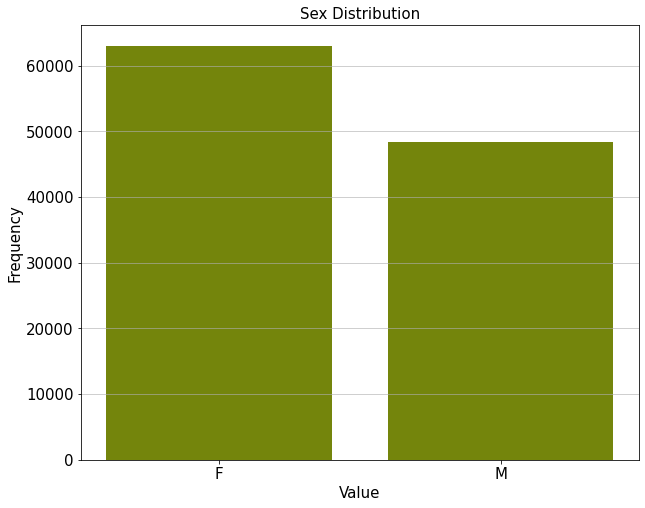

In [28]:
sex = dat['Sex'].value_counts()
sex = pd.DataFrame(sex)
sex = sex.reset_index()
sex = sex.sort_values(by = ["index"], ascending = True)
sex

plt.figure(figsize=[10,8])

plt.bar(sex['index'], sex['Sex'], color = '#74850c')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Sex Distribution',fontsize=15)
plt.show()

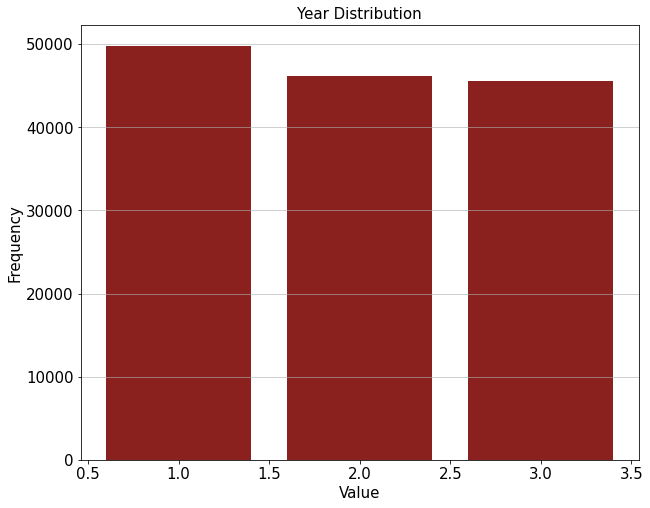

In [30]:
Year = dat['Year'].value_counts()
Year = pd.DataFrame(Year)
Year = Year.reset_index()
Year = Year.sort_values(by = ["index"], ascending = True)


plt.figure(figsize=[10,8])

plt.bar(Year['index'], Year['Year'], color = '#8a211e')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Year Distribution',fontsize=15)
plt.show()

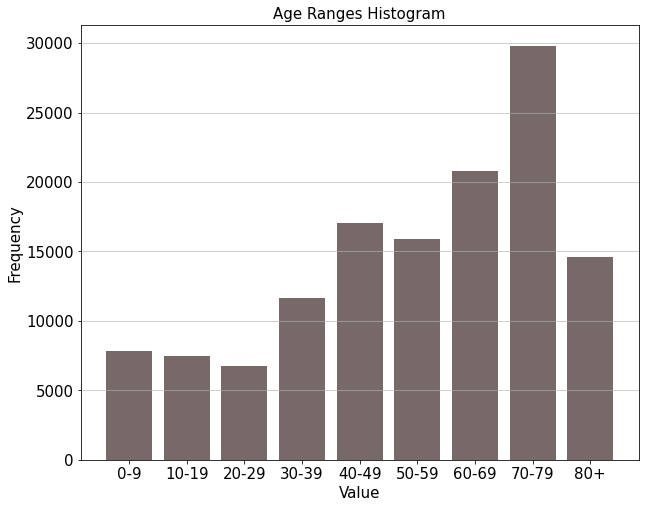

In [31]:
plt.figure(figsize=[10,8])

plt.bar(age['index'], age['AgeAtFirstClaim'], color = '#786969')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Age Ranges Histogram',fontsize=15)
plt.show()

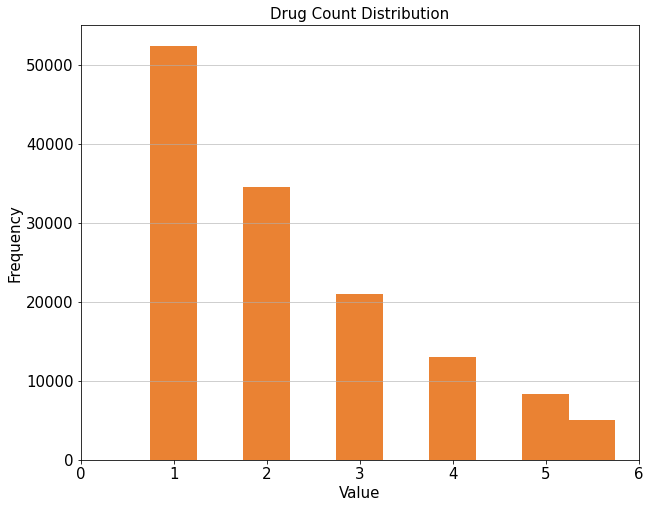

In [32]:
printplot("DrugCount", '#e56300', "Drug Count Distribution")

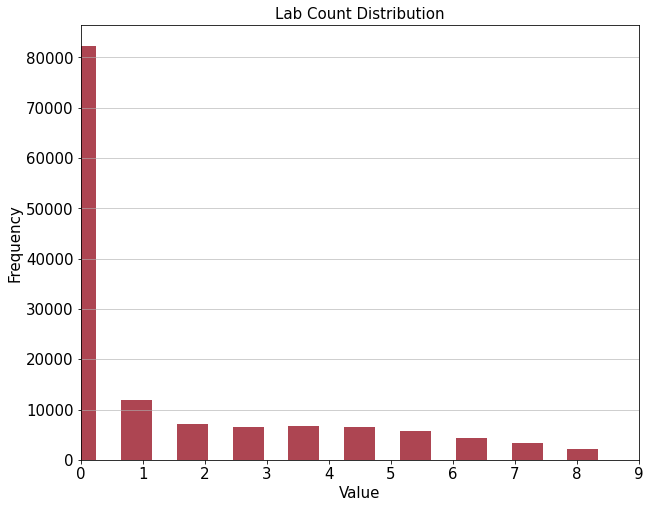

In [33]:
printplot("LabCount", '#991727', "Lab Count Distribution")

### Outcome Visualized

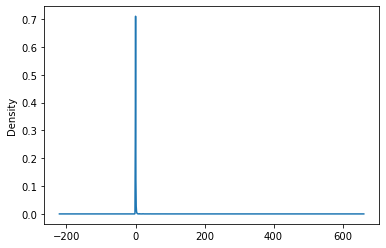

In [34]:
dat['length_recoded'].plot(kind = 'density')

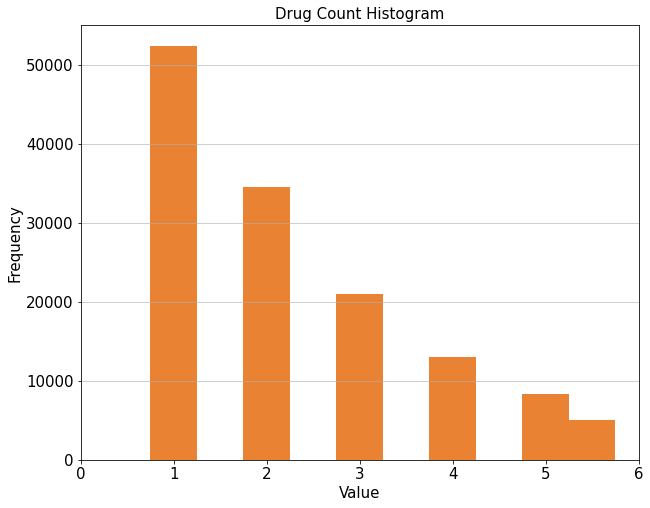

In [35]:
drugcount = dat[["DrugCount"]].dropna(axis = 0)
dchist,dcbin_edges = np.histogram(drugcount)

plt.figure(figsize=[10,8])

plt.bar(dcbin_edges[:-1], dchist, width = 0.5, color='#e56300',alpha=0.8)
plt.xlim(0, np.ceil(max(dcbin_edges)))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Drug Count Histogram',fontsize=15)
plt.show()

## Modeling

Since we're looking at multiple outcomes with a series of co-variates, decision tree learning would be most appropriate in this scenario. This is further supported knowing that the winning methods used extended decision tree modeling for their predictive analyses.

In [125]:
indices = list(range(9,55,1))
x = list(range(5,8,1))
indices = indices + x 
indices.append(1)

In [126]:
X = dat.iloc[:,indices]
Y = dat.iloc[:,55]

In [127]:
X = pd.get_dummies(data=X, drop_first=True)
X = X.dropna(axis = 1)

In [128]:
X.head(3)

,APPCHOL,ARTHSPIN,CANCRA,CANCRB,CANCRM,CATAST,CHF,COPD,FLaELEC,FXDISLC,...,DSFS,Year,AgeAtFirstClaim_10-19,AgeAtFirstClaim_20-29,AgeAtFirstClaim_30-39,AgeAtFirstClaim_40-49,AgeAtFirstClaim_50-59,AgeAtFirstClaim_60-69,AgeAtFirstClaim_70-79,AgeAtFirstClaim_80+
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,1,0,0,1,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,3,0,0,1,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,1,0,0,0,0,0,0,0,0


In [40]:
Y.describe()

count    141558.000000
mean          0.342220
std           4.711622
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         441.000000
Name: length_recoded, dtype: float64

In [105]:
X.shape

(141558, 55)

### Linear Regression: Low SES

While `low_SES` was an engineered feature, based on the patient's pay delay, I was curious what it's impact was on other features. This was a question of my own (external to the challenge). I fit an OLS Linear Regression Model. The `low_SES` coefficient, when controlling for age categories, was statistically significantly associated (β = 2.6505, p < 0.0001) with the total number of conditions attributed toward hospitalization (per patient). Nothing definitive can be concluded from this, but it is still an interesting observation altogether. 

In [157]:
X1 = X
s = range(0,44, 1)
X1['sum'] = np.sum(X1.iloc[:,s], axis = 1)

In [158]:
s = [*range(48,56, 1)]
s = s + [44]
X1 = X1.iloc[:,s]

In [169]:
Y1 = X1['sum']
X2 = X1[['AgeAtFirstClaim_20-29', 'AgeAtFirstClaim_30-39',
        'AgeAtFirstClaim_40-49', 'AgeAtFirstClaim_50-59',
        'AgeAtFirstClaim_60-69', 'AgeAtFirstClaim_70-79',
        'AgeAtFirstClaim_80+', 'low_SES']]

In [171]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
#lin_reg = LinearRegression()
#lin_reg.fit(X2, Y1)
#lin_reg.intercept_, lin_reg.coef_

est = sm.OLS(Y1, X2)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                    sum   R-squared (uncentered):                   0.725
Model:                            OLS   Adj. R-squared (uncentered):              0.725
Method:                 Least Squares   F-statistic:                          4.672e+04
Date:                Fri, 02 Oct 2020   Prob (F-statistic):                        0.00
Time:                        21:02:31   Log-Likelihood:                     -3.3906e+05
No. Observations:              141558   AIC:                                  6.781e+05
Df Residuals:                  141550   BIC:                                  6.782e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Classification Models: Decision Tree

Note that this tree was fit without any dimmensionality reduction. As a result, there's definitely room for pruning and making the model more parsimonious. While the tree is ridiculously large and not as helpful as we'd like, the feature importance is worth noting: besides the time variables, `RESPR4` (*acute respiratory infections*), `ARTHSPIN` (*arthropathies and spine disorders*), `NEUMENT`(*neurological problems*), and `low_SES` were ranked the most important features. Overall, the model was 77.4% accurate.

In [48]:
Y = Y.apply(str)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [50]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=11)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=11)

In [51]:
from sklearn import tree
text_representation = tree.export_text(tree_clf)
print(text_representation)

|--- feature_45 <= 12.50
|   |--- feature_10 <= 0.50
|   |   |--- feature_42 <= 0.50
|   |   |   |--- feature_45 <= 7.50
|   |   |   |   |--- feature_45 <= 3.50
|   |   |   |   |   |--- feature_45 <= 1.50
|   |   |   |   |   |   |--- feature_17 <= 0.50
|   |   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_9 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_11 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_43 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |   |   |   |   |   |   |--- feature_43 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- feature_11 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_47 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- feature_47 >  0.50
|   |   |   |   |   |   |   |   |

In [52]:
features = pd.DataFrame(X.columns.values)
imp = pd.DataFrame(tree_clf.feature_importances_)
features_df = pd.concat([features, imp], axis = 1)

In [53]:
features_df.columns= ["features", "importance"]
features_df = features_df.sort_values(by = ["importance"], ascending = False)
features_df.head(10)

,features,importance
45,DSFS,0.188571
46,Year,0.062379
1,ARTHSPIN,0.037378
44,low_SES,0.037099
36,RESPR4,0.035005
26,NEUMENT,0.034198
22,MISCHRT,0.031744
18,INFEC4,0.030325
25,MSC2a3,0.027085
40,SKNAUT,0.026664


In [104]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import auc
from sklearn import metrics
pred = tree_clf.predict(X_test) 
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))

Accuracy: 0.774


### Classification Models: Random Forest

For this model, I utilized a grid search to optimize parameters based on accuracy and refit accordingly. The model was 86.7% accurate. Furthermore, one of the key advantages of random forest was being able to visualize feature importance. `GIBLEED` and `ROAMI` were the leading clinical features. 

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
rnd_clf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=16, n_jobs=-1, random_state = 11) 
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [186]:
param_grid = { "n_estimators": [100, 200, 250],
              "max_depth": [1, 5, 7, 11], 
              "criterion": ["gini", "entropy"] }

In [191]:
model = model_selection.GridSearchCV( estimator=rnd_clf, param_grid=param_grid, 
                                     scoring="accuracy", 
                                     verbose=10, 
                                     n_jobs=1, cv=2 )
model.fit(X_train, y_train)
print(f"Best score: {model.best_score_}")
print("Best parameters set:", model.best_estimator_.get_params())

#Based on this grid search, we can use max_depth = 1 and n_estimators = 100

In [193]:
rnd_clf = RandomForestClassifier(n_estimators=100, max_depth = 1, n_jobs=-1, random_state = 11) 
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred_rf)))

Accuracy: 0.867


In [215]:
feat = np.array(['name', 'score'])
for name, score in zip(X.columns.values, rnd_clf.feature_importances_): 
    z = np.array([name, score])
    feat = np.vstack((feat, z))

feature_tbl = pd.DataFrame(feat[1:,], columns = feat[0])
feature_tbl = feature_tbl.sort_values(by = ["score"], ascending = False)
feature_tbl.head()

,name,score
10,GIBLEED,0.15
45,DSFS,0.13
37,ROAMI,0.12
42,TRAUMA,0.09
27,ODaBNCA,0.07
